In [1]:
from collections import defaultdict
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow_datasets as tfds

# Helper Code

In [2]:
class TestCallback(Callback):
    def __init__(self, log_dir, x_test, y_test):
        
        self.writer = tf.summary.create_file_writer(log_dir)
        self.x_test = x_test
        self.y_test = y_test
        
    def on_epoch_end(self, epoch, logs=None):
        
        test_scores = model.evaluate(self.x_test, self.y_test, verbose=2)

        with self.writer.as_default():
            tf.summary.scalar('epoch_loss', test_scores[0], step=epoch)
            tf.summary.scalar('epoch_accuracy', test_scores[1], step=epoch)

In [3]:
def variable_summaries(var, name, step):
    with tf.name_scope(name):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean, step)
        tf.summary.scalar('stddev', tf.sqrt(tf.reduce_mean(tf.square(var - mean))), step)
        tf.summary.scalar('max', tf.reduce_max(var), step)
        tf.summary.scalar('min', tf.reduce_min(var), step)

# More Helper Code (bers)

In [4]:
def tf_nan(dtype):
    """Create NaN variable of proper dtype and variable shape for assign()."""
    return tf.Variable(float("nan"), dtype=dtype, shape=tf.TensorShape(None))

In [5]:
class DataCallback(Callback):
    """Callback to operate on batch data from selected (to be wrapped) layers."""
    
    def __init__(self, log_dir, layers):
        """Wrap the calls of an iterable of model layers to access layer batch data."""
        super().__init__()
        
        self.data = {}
        self.inner_calls = {}
        self.outer_calls = {}
        
        self.writer = tf.summary.create_file_writer(log_dir) 
        self.batch = tf.Variable(0, dtype=tf.int64)
        
        for layer in layers:
            self.data[layer] = {
                "inputs":  tf_nan(layer.input.dtype),
                "outputs": tf_nan(layer.output.dtype)
            }
            
            self.inner_calls[layer] = layer.call
            
            def outer_call(inputs, layer=layer, layer_call=layer.call, training=False):
                self.data[layer]["inputs"].assign(inputs)
                outputs = layer_call(inputs)
                self.data[layer]["outputs"].assign(outputs)
                return outputs
            
            self.outer_calls[layer] = outer_call
            
    def on_train_batch_begin(self, _epoch, _logs=None):
        """Wrap layer calls during each batch."""
        for layer, call in self.outer_calls.items():
            layer.call = call
            
    def on_train_batch_end(self, _epoch, _logs=None):
        """Restore original layer calls for ModelCheckpoint, model.save, ...,"""
        for layer, call in self.inner_calls.items():
            layer.call = call
            
        self.batch.assign_add(1)
        
        if self.batch % 100 == 0:
            with self.writer.as_default():
                for layer, data in self.data.items():
                    if isinstance(layer, keras.layers.InputLayer):
                        continue
                    
                    tf.summary.histogram(f'{layer.name}/input/histogram', data['inputs'], step=self.batch)
                    tf.summary.histogram(f'{layer.name}/output/histogram', data['outputs'], step=self.batch)
                    
                    variable_summaries(data['inputs'], f'{layer.name}/input', step=self.batch)
                    variable_summaries(data['outputs'], f'{layer.name}/output', step=self.batch)
                    
                    
                    if isinstance(layer, Conv2D) or isinstance(layer, Dense):
                        tf.summary.histogram(f'{layer.name}/kernel/histogram', layer.kernel, step=self.batch)
                        tf.summary.histogram(f'{layer.name}/layer_bias/histogram', layer.bias, step=self.batch)
                        
                        variable_summaries(layer.kernel, f'{layer.name}/kernel', self.batch)
                        variable_summaries(layer.bias, f'{layer.name}/layer_bias', self.batch)

# Loading MNIST Data Offline

In [2]:
# Downloaded from https://s3.amazonaws.com/img-datasets/mnist.pkl.gz
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data(path='mnist.pkl.gz')
train_images = tf.cast(train_images, tf.float32) / 255.
test_images = tf.cast(test_images, tf.float32) / 255.

In [4]:
train_images.shape, train_labels.shape

(TensorShape([60000, 28, 28]), (60000,))

# Model

In [7]:
## Hyperparameters

#initializer = tf.initializers.GlorotUniform() # Glorot = Xavier
#actFun = lambda x : tf.nn.leaky_relu(x, alpha=0.2)
#weight_init = GlorotNormal()
weight_init = TruncatedNormal(stddev=0.1, seed=0)
bias_init = Constant(value=0.1)
actFun = Activation(tf.nn.relu)
actFun = Activation(tf.nn.sigmoid)

lr = 1e-4
optimizer = Adam(lr) # SGD, momentum-based methods, Adagrad
#optimizer = SGD(learning_rate=0.01)
#optimizer = Adagrad()
#optimizer = Nadam()
print(optimizer.learning_rate)
dropout = 0.5
batch = 50
epochs = 5 # 5.5k iterations of 50-image batches from a 55k image dataset = 5 epochs through the whole dataset

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [8]:
model_input = Input(shape=(28,28, 1), name='0__original_img')

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', activation=actFun,
           kernel_initializer=weight_init, bias_initializer=bias_init, name='1__conv1')(model_input) # use_bias=True by default

x = MaxPooling2D(padding='same', name='2__pool1')(x) # default strides = default pool size = (2,2)


x = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation=actFun,
           kernel_initializer=weight_init, bias_initializer=bias_init, name='3__conv2')(x)
x = MaxPooling2D(padding='same', name='4__pool2')(x)


x = Reshape([-1, 7*7*64], name='5__reshape')(x)
x = Dense(1024, activation=actFun,
          kernel_initializer=weight_init, bias_initializer=bias_init, name='6__dense1')(x)
x = Dropout(rate=0.5, seed=0, name='7__dropout')(x)


x = Dense(10, activation='softmax',
          kernel_initializer=weight_init, bias_initializer=bias_init, name='8__dense2')(x)

model_output = x

model = keras.Model(model_input, model_output, name='model')
#model.summary()

In [9]:
if 'logs' in os.listdir():
    shutil.rmtree('logs')

In [10]:
current_time = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
log_dir = 'logs/fit/' + current_time
callback1 = TensorBoard(log_dir=log_dir)
callback2 = DataCallback(log_dir=log_dir + '/activations', layers=model.layers)
callback3 = TestCallback(log_dir=log_dir + '/test', x_test=test_images, y_test=test_labels)

In [11]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy']
)

#history = model.fit(test_images, test_labels, batch_size=50, epochs=2, validation_split=5/60, callbacks=[callback1, callback2, callback3])
history = model.fit(train_images, train_labels, batch_size=50, epochs=epochs, validation_split=5/60, callbacks=[callback1, callback2, callback3])

Epoch 1/5
1100/1100 [==============================] - 149s 135ms/step - loss: 1.3879 - accuracy: 0.5526 - val_loss: 0.4119 - val_accuracy: 0.8972
313/313 - 6s - loss: 0.4744 - accuracy: 0.8730
Epoch 2/5
1100/1100 [==============================] - 142s 129ms/step - loss: 0.3856 - accuracy: 0.8887 - val_loss: 0.2397 - val_accuracy: 0.9356
313/313 - 6s - loss: 0.2876 - accuracy: 0.9172
Epoch 3/5
1100/1100 [==============================] - 146s 132ms/step - loss: 0.2639 - accuracy: 0.9242 - val_loss: 0.1666 - val_accuracy: 0.9556
313/313 - 6s - loss: 0.1993 - accuracy: 0.9437
Epoch 4/5
1100/1100 [==============================] - 143s 130ms/step - loss: 0.1952 - accuracy: 0.9414 - val_loss: 0.1536 - val_accuracy: 0.9554
313/313 - 6s - loss: 0.1777 - accuracy: 0.9443
Epoch 5/5
1100/1100 [==============================] - 144s 131ms/step - loss: 0.1484 - accuracy: 0.9555 - val_loss: 0.1024 - val_accuracy: 0.9714
313/313 - 6s - loss: 0.1177 - accuracy: 0.9661


In [12]:
%load_ext tensorboard


%tensorboard --logdir logs --host localhost --port 6004

Reusing TensorBoard on port 6004 (pid 15176), started 9:08:52 ago. (Use '!kill 15176' to kill it.)

In [14]:
tf_event_file = log_dir + '/activations/' + os.listdir(log_dir + '/activations')[0]

value_list = defaultdict(list)
for e in tf.compat.v1.train.summary_iterator(tf_event_file):
    for v in e.summary.value:
        #print(v.tag)
        #if TAG_NAME in v.tag:
        value = tf.make_ndarray(v.tensor)
        value_list[v.tag].append(value)

value_list = {k: np.array(v) for k, v in value_list.items()}

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [15]:
arr = [x for x in list(value_list.keys()) if 'histogram' not in x]

In [16]:
n = len(value_list['1__conv1/input/mean'])
xaxis = (np.arange(n) + 1) * 100

weight_init_name = str(type(weight_init)).split("'")[1].split('.')[-1]
actFun_name = str(actFun.activation).split()[1]
optimizer_name = str(type(optimizer)).split("'")[1].split('.')[-1]

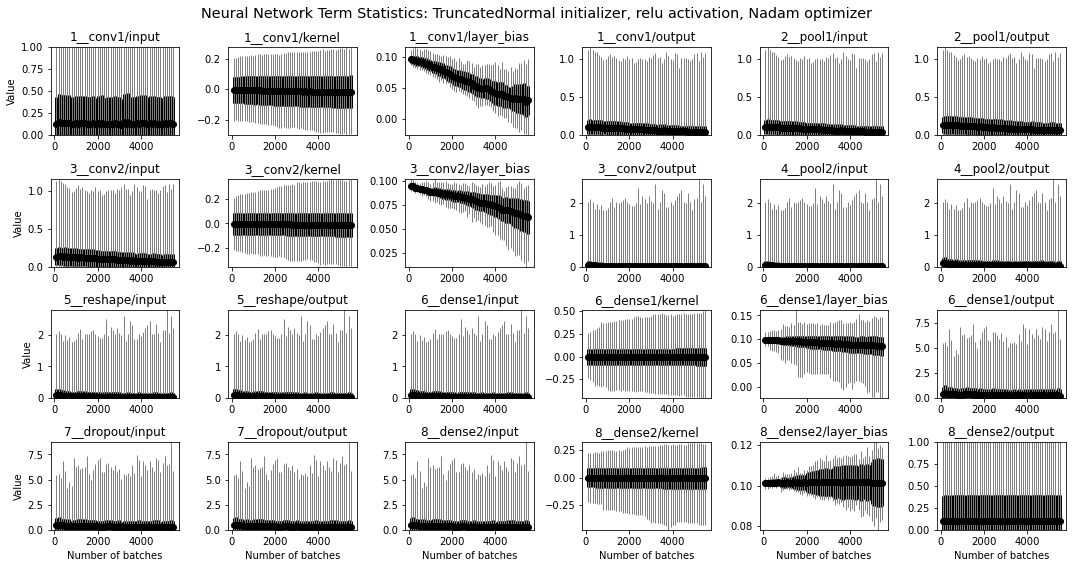

In [17]:
fig, axs = plt.subplots(4, 6, figsize=(15,8))

idx = 0

for layer in np.unique([x.split('/')[0] for x in arr]):
    for part in ['input', 'kernel', 'layer_bias', 'output']:
        if 'conv' not in layer and 'dense' not in layer and (part == 'kernel' or part == 'layer_bias'):
            continue
            
        idx1 = idx // 6
        idx2 = idx % 6
        
        name = layer + '/' + part + '/'

        means = value_list[name + 'mean']
        std = value_list[name + 'stddev']
        mins = value_list[name + 'min']
        maxes = value_list[name + 'max']
        
        axs[idx1, idx2].set_title(name[:-1])
        
        axs[idx1, idx2].errorbar(xaxis, means, std, fmt='ok', lw=3)
        axs[idx1, idx2].errorbar(xaxis, means, [means - mins, maxes - means], fmt='.k', ecolor='gray', lw=1)
        axs[idx1, idx2].set_ylim(min(mins), max(maxes))
        
        idx += 1
        
plt.suptitle(f'Neural Network Term Statistics: {weight_init_name} initializer, {actFun_name} activation, {optimizer_name} optimizer',
             size='x-large')
#plt.text(0, 0, 'common xlabel', ha='center', va='center')
plt.setp(axs[-1, :], xlabel='Number of batches')
plt.setp(axs[:, 0], ylabel='Value')
plt.tight_layout()